# Problem: Forecasting Stock Prices using Time Series Modeling
After the Gamestop fiasco with the subredit Wallstreetbets, I became very interested in doing a project with the stock market. The purpose of this project is to see if I can forecast stock prices using time-series modeling
## Method: ARIMA
## Data: Stock market prices from TDAmeritrade API
## Libraries:
- numpy
- pandas
- statsmodels
- requests
- plotly

## Import Libraries
We will be working with numpy, pandas, plotly, requests, and datetime

In [1]:
# Libraries for handling data
from information import client_id
import requests
import numpy as np
import pandas as pd
from datetime import datetime
import random

# For visualizations
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# For time series modeling
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

## Get our data using TDAmeritrade API

In [2]:
def get_data(symbol,
             client_id,
             periodType = 'year',
             n_periods = 20,
             frequencyType = 'daily',
             frequency = 1):
    """
    Yields a dataframe of  close price data for the given parameters
    
    --Parameters--
    
    symbol: Ticker symbol
    
    periodType: The type of period to show. Valid values are day, month, year, or ytd (year to date). Default is            day.
        
    n_periods: 	The number of periods to show.

        Example: For a 2 day / 1 min chart, the values would be:

        period: 2
        periodType: day
        frequency: 1
        frequencyType: min

        Valid periods by periodType (defaults marked with an asterisk):

        day: 1, 2, 3, 4, 5, 10*
        month: 1*, 2, 3, 6
        year: 1*, 2, 3, 5, 10, 15, 20
        ytd: 1*

    frequencyType: The type of frequency with which a new candle is formed. Valid frequencyTypes by periodType              (defaults marked with an asterisk):

        day: minute*
        month: daily, weekly*
        year: daily, weekly, monthly*
        ytd: daily, weekly*
    
    frequency: The number of the frequencyType to be included in each candle.

        Valid frequencies by frequencyType (defaults marked with an asterisk):

        minute: 1*, 5, 10, 15, 30
        daily: 1*
        weekly: 1*
        monthly: 1*
    
    """  
    # Initialize parameters
    parameters = {
        'apikey': client_id,
        'periodType': periodType,
        'period': str(n_periods),
        'frequencyType': frequencyType,
        'frequency': str(frequency),
    }
    
    # Request from API
    api_url = f'https://api.tdameritrade.com/v1/marketdata/{symbol}/pricehistory'
    data = requests.get(url = api_url, params = parameters).json()
    
    # Create dataframe
    dataframe = pd.DataFrame(data['candles'])

    # Convert to datetime format
    for i in range(len(dataframe['datetime'])):
        dataframe['datetime'][i] = datetime.fromtimestamp(dataframe['datetime'][i]/1000)
    
    # Set datetime to be our index
    dataframe = dataframe.set_index('datetime')

    # Remove open, high, low, and volumn columns.
    # For this project, we will be working only with the close price
    dataframe.drop(labels=[
                            'open',
                            'high',
                            'low',
                            'volume'
                            ], axis=1,
                            inplace=True
                    )
    
    return dataframe, symbol

In [3]:
dataframe, symbol = get_data(symbol='DIA',
                     client_id=client_id,
                     periodType = 'year',
                     n_periods = 20,
                     frequencyType = 'daily',
                     frequency = 1)

dataframe

<ipython-input-2-633b6772e4e4>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['datetime'][i] = datetime.fromtimestamp(dataframe['datetime'][i]/1000)


,close
datetime,
2004-08-18 22:00:00,50.218619
2004-08-19 22:00:00,54.207480
2004-08-22 22:00:00,54.753009
2004-08-23 22:00:00,52.485814
2004-08-24 22:00:00,53.051361
...,...
2021-08-01 22:00:00,2697.090000
2021-08-02 22:00:00,2712.600000
2021-08-03 22:00:00,2702.510000


#### Let's check for NaN values

In [4]:

dataframe[dataframe.isna().any(axis=1)]

# If NaN value exist, use dataframe.dropna() to remove those rows
# dataframe.dropna(inplace=True)

,close
datetime,


#### High-level look at the dataframe

In [5]:
# Check out the details of the dataframe

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4272 entries, 2004-08-18 22:00:00 to 2021-08-05 22:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   4272 non-null   float64
dtypes: float64(1)
memory usage: 66.8 KB


## Plot the Data

In [6]:
fig = go.Figure(data=go.Line(x=dataframe.index, y=dataframe['close']))
fig.update_layout(title=f'{symbol}',
                   xaxis_title='Year',
                   yaxis_title='Close Price')
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

  warnings.warn(


## Calculate Returns

In [7]:
def calc_return(dataframe, lag=1):
    """
    Adds a column of the previous close to the dataframe.
    """
    prevClose = [x for x in dataframe['close'][:-lag]]
    prevClose = [np.nan for i in range(lag)] + prevClose
    dataframe[f'{lag}-day prevClose'] = prevClose
    dataframe['return'] = np.log(dataframe['close'] / dataframe[f'{lag}-day prevClose']).shift(1)
    
    return dataframe

In [8]:
calc_return(dataframe, lag=1).head(10)

,close,1-day prevClose,return
datetime,,,
2004-08-18 22:00:00,50.218619,NaN,NaN
2004-08-19 22:00:00,54.207480,50.218619,NaN
2004-08-22 22:00:00,54.753009,54.207480,0.076433
2004-08-23 22:00:00,52.485814,54.753009,0.010013
2004-08-24 22:00:00,53.051361,52.485814,-0.042289
2004-08-25 22:00:00,54.007287,53.051361,0.010718
2004-08-26 22:00:00,53.126434,54.007287,0.017858
2004-08-29 22:00:00,51.054428,53.126434,-0.016444
2004-08-30 22:00:00,51.234602,51.054428,-0.039782


#### Plot Returns

In [9]:
fig = go.Figure(data=go.Line(x=dataframe.index, y=dataframe['return']))
fig.update_layout(title=f'{symbol} Returns',
                  xaxis_title='Year',
                  yaxis_title='Return')
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# Test for stationarity: Dickey-Fuller Test
Stationarity implies the mean and standard deviation of the returns have no correlation with time. This is important because it allows for stability and some level of certainty in forecasting model

#### Calculate Rolling Mean and Standard Deviation

In [10]:
def mean_std(dataframe, length=20):
    """
    Adds 2 columns to our dataframe: A rolling mean and standard deviations of user-defined lengths
    """
    dataframe[f'sma{length}'] = dataframe['return'].rolling(length).mean()
    dataframe[f'std{length}'] = dataframe['return'].rolling(length).std()
    # Remove leading NaNs
    dataframe.dropna(inplace=True)

In [11]:
mean_std(dataframe)


In [12]:
dataframe

,close,1-day prevClose,return,sma20,std20
datetime,,,,,
2004-09-19 22:00:00,59.737835,58.801928,0.030418,0.007889,0.026885
2004-09-20 22:00:00,58.977098,59.737835,0.015791,0.004857,0.021660
2004-09-21 22:00:00,59.247360,58.977098,-0.012816,0.003716,0.021973
2004-09-22 22:00:00,60.468542,59.247360,0.004572,0.006059,0.019123
2004-09-23 22:00:00,59.973062,60.468542,0.020402,0.006543,0.019368
...,...,...,...,...,...
2021-08-01 22:00:00,2697.090000,2694.530000,-0.007771,0.004779,0.014202
2021-08-02 22:00:00,2712.600000,2697.090000,0.000950,0.003691,0.013576
2021-08-03 22:00:00,2702.510000,2712.600000,0.005734,0.003607,0.013557


In [13]:
fig = go.Figure()
fig.add_trace(go.Line(x=dataframe.index, y=dataframe['return'], name='Returns',
                         line=dict(color='blue', width=1)))
fig.add_trace(go.Line(x=dataframe.index, y=dataframe.iloc[:,3], name = dataframe.columns[3],
                         line=dict(color='red', width=1)))
fig.add_trace(go.Line(x=dataframe.index, y=dataframe.iloc[:,4], name=dataframe.columns[4],
                         line=dict(color='black', width=1)
))

fig.update_layout(title=f'{symbol}',
                   xaxis_title='Year')
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### Perform Dickey-Fuller Test

In [14]:
dftest = sm.tsa.adfuller(dataframe['return'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                 -27.981085
p-value                          0.000000
#Lags Used                       5.000000
Number of Observation Used    4245.000000
Critical Value (1%)             -3.431891
Critical Value (5%)             -2.862221
Critical Value (10%)            -2.567133
dtype: float64

With a p-value < 0.05, we can reject the null hypothesis that there is a unit root. This data set is stationary.

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them. 

#### ACF

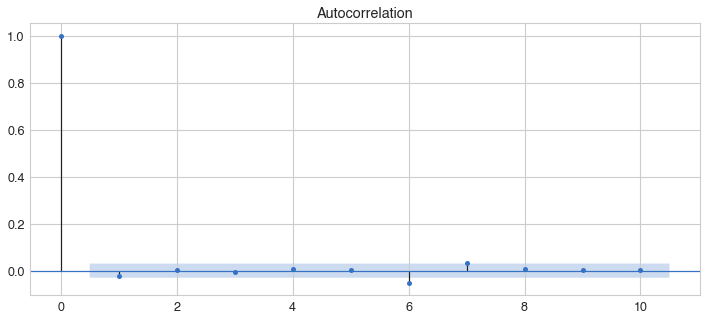

In [15]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(dataframe['return'], lags=10, ax=ax)
plt.show()

#### PACF

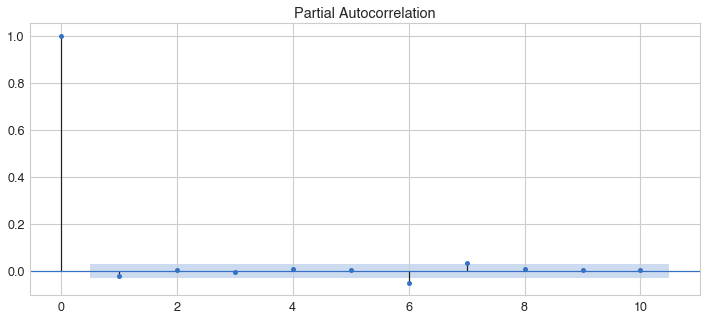

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(dataframe['return'], lags=10, ax=ax)
plt.show()

The above charts show the ACF and PACF readings give us a lag "p" of 6 and a lag "q" of 6

## Build ARIMA Model

In [17]:
ar1 = ARMA(tuple(dataframe['return']), (1,1)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 4251
Model:                     ARMA(1, 1)   Log Likelihood               10823.937
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sun, 08 Aug 2021   AIC                         -21639.874
Time:                        10:39:58   BIC                         -21614.454
Sample:                             0   HQIC                        -21630.891
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      3.190      0.001       0.000       0.001
ar.L1.y       -0.2177      0.694     -0.314      0.754      -1.578       1.143
ma.L1.y        0.1933      0.698      0.277      0.782      -1.174       1.561
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.5930           +0.0000j            4.5930            0.5000
MA.1           -5.1742           +0.0000j            5.1742            0.5000
-----------------------------------------------------------------------------
"""

In [18]:
preds = ar1.fittedvalues

#### Plot Predictions (Returns)

In [19]:
fig = go.Figure()
fig.add_trace(go.Line(x=dataframe.index, y=dataframe['return'], name='Returns',
                         line=dict(color='blue', width=1)))
fig.add_trace(go.Line(x=dataframe.index, y=preds, name = 'Predictions',
                         line=dict(color='red', width=1)
))

fig.update_layout(title='Predictions vs Actual Returns',
                   xaxis_title='Year')
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### Plot Predictions (Close Price)

In [20]:
dataframe['predictions'] = dataframe[dataframe.columns[1]] * (1 + preds)
dataframe

,close,1-day prevClose,return,sma20,std20,predictions
datetime,,,,,,
2004-09-19 22:00:00,59.737835,58.801928,0.030418,0.007889,0.026885,58.855401
2004-09-20 22:00:00,58.977098,59.737835,0.015791,0.004857,0.021660,59.748836
2004-09-21 22:00:00,59.247360,58.977098,-0.012816,0.003716,0.021973,59.017529
2004-09-22 22:00:00,60.468542,59.247360,0.004572,0.006059,0.019123,59.323689
2004-09-23 22:00:00,59.973062,60.468542,0.020402,0.006543,0.019368,60.513686
...,...,...,...,...,...,...
2021-08-01 22:00:00,2697.090000,2694.530000,-0.007771,0.004779,0.014202,2697.622640
2021-08-02 22:00:00,2712.600000,2697.090000,0.000950,0.003691,0.013576,2699.990937
2021-08-03 22:00:00,2702.510000,2712.600000,0.005734,0.003607,0.013557,2714.976971


In [21]:
# Plot last 200 days for visibility
WINDOW_LENGTH = 400

fig = go.Figure()
fig.add_trace(go.Line(x=dataframe.index[-WINDOW_LENGTH:], y=dataframe['close'][-WINDOW_LENGTH:], name='Close Price',
                         line=dict(color='blue', width=1)))
fig.add_trace(go.Line(x=dataframe.index[-WINDOW_LENGTH:], y=dataframe['predictions'][-WINDOW_LENGTH:], name = 'Predictions',
                         line=dict(color='red', width=1)
))

fig.update_layout(title='Predictions vs Actual Returns',
                   xaxis_title='Year')
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Forecast

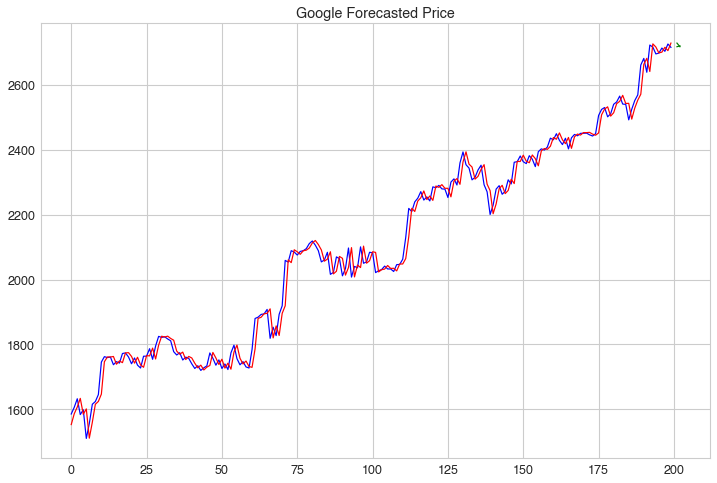

In [22]:
# Define number of steps to take
steps = 2

# Define forecast array for 2 days into the future
forecast = ar1.forecast(steps=steps)[0]
forecast1 = dataframe['close'][-1] * (1 + forecast[0])
forecast2 = forecast1 * (1 + forecast[1])
forecast_array = np.array([forecast1, forecast2])

# Plot close price
plt.figure(figsize=(12, 8))
plt.plot(dataframe['close'][-200:].values, color='blue')

# Plot predicted close price
preds=dataframe['predictions'][-200:].values
plt.plot(preds, color='red')

# Plot forecasts
plt.plot(
    pd.DataFrame(
        np.array(
            [
                preds[-1], forecast1
            ]
        ).T,
        index = range(
            len(
                dataframe['close'][-200:].values
            ) + 1,
            len(
                dataframe['close'][-200:].values
            ) + 3
        )
    ), color='green'
)

plt.plot(
    pd.DataFrame(
        forecast_array,
        index = range(
            len(
                dataframe['close'][-200:].values
            ) + 1,
            len(
                dataframe['close'][-200:].values
            ) + 1 + steps
        )
    ), color = 'green'
)

plt.title('Google Forecasted Price')
plt.show()

## Residuals

In [23]:
residuals = abs(dataframe['predictions'] - dataframe['close'])

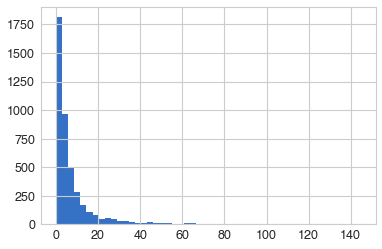

In [24]:
plt.hist(residuals.values, bins=50)
plt.show();

In [27]:
print("Mean Absolute Error: %.3f" % np.mean(residuals))
print("Standard Deviation: %.3f" % np.std(residuals))
print("AIC: %.3f" % ar1.aic)
print("Max residual: %.3f" % np.max(residuals))

Mean Absolute Error: 7.213
Standard Deviation: 11.322
AIC: -21639.874
Max residual: 144.576


# Conclusion

- The AIC of our mode is small at -20964.701. But does this equate to a good model? Probably not.
- If we check the errors (predictions - close price), the mean absolute error is approximately 1.301, which may lead to some losses.
- At one point the model prediction was off by 144, these trades would have resulted in enormous losses. 